# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                     
Sample_158  A0A0C4DH07;Q8N2S1;Q8N2S1-2;Q8N2S1-3   17.591
Sample_033  P05534                                17.465
Sample_203  Q8TDF5;Q8TDF5-1;Q8TDF5-2              14.957
Sample_019  A0A0A0MSN4;P12821;P12821-2            14.490
Sample_016  P13591                                21.202
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups                                     
Sample_038  P51688                                                13.472
Sample_050  A0A0C4DG76;Q5JZ08;Q9BQS7;Q9BQS7-2;Q9BQS7-3;Q9BQS7-4   17.373
Sample_016  Q9UJQ1;Q9UJQ1-2                                       15.454
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.162
            A0A075B6Q5                 12.672
            A0A075B6R2                 12.951
            A0A075B6S5                 13.717
            A0A087WSY4                 12.475
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.815
            Q9UI40;Q9UI40-2            12.224
            Q9UIW2                     12.635
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.487
            Q9UP79                     12.863
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.376,15.050,16.842,19.863,15.835,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.720,19.067,...,15.528,15.576,14.145,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.586,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.777,17.705,17.039,16.167,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.693,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.252,15.345,17.084,18.708,14.249,19.433,11.911,11.110
Sample_207,15.739,16.877,15.469,16.898,14.808,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,10.939,12.921,12.684,12.284,12.671,13.586,12.769,12.508,13.093,12.786
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.057,19.067,16.127,...,12.791,12.794,12.262,13.147,12.633,11.558,12.298,12.476,12.487,13.306
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.066,12.743,14.324,13.648,11.850,13.502,14.371,12.735,13.454,12.445
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.599,11.254,12.544,14.045,13.113,12.853,11.912,11.564,12.021,12.979
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,14.069,12.635,13.863,13.811,11.939,12.422,13.459,12.935,11.838,12.866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,11.763,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 332.14it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.15it/s]

100%|██████████| 2/2 [00:00<00:00,  5.96it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  8.16it/s]

100%|██████████| 3/3 [00:00<00:00,  5.33it/s]

100%|██████████| 3/3 [00:00<00:00,  5.70it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.44it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.58it/s]

100%|██████████| 4/4 [00:00<00:00,  4.70it/s]

100%|██████████| 4/4 [00:00<00:00,  5.18it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.44it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.81it/s]

 80%|████████  | 4/5 [00:00<00:00,  5.23it/s]

100%|██████████| 5/5 [00:00<00:00,  4.79it/s]

100%|██████████| 5/5 [00:00<00:00,  5.21it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.42it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.09it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.37it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.31it/s]

100%|██████████| 6/6 [00:01<00:00,  4.49it/s]

100%|██████████| 6/6 [00:01<00:00,  4.65it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.73it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.76it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.45it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.18it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.08it/s]

100%|██████████| 7/7 [00:01<00:00,  3.89it/s]

100%|██████████| 7/7 [00:01<00:00,  4.20it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.84it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.27it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.98it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.80it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.75it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.85it/s]

100%|██████████| 8/8 [00:02<00:00,  3.83it/s]

100%|██████████| 8/8 [00:02<00:00,  3.97it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.10it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.52it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.30it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.26it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.97it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.78it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.68it/s]

100%|██████████| 9/9 [00:02<00:00,  3.77it/s]

100%|██████████| 9/9 [00:02<00:00,  4.02it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.60it/s]

 30%|███       | 3/10 [00:00<00:01,  4.36it/s]

 40%|████      | 4/10 [00:00<00:01,  4.20it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.19it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.99it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.76it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.61it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.74it/s]

100%|██████████| 10/10 [00:02<00:00,  3.78it/s]

100%|██████████| 10/10 [00:02<00:00,  3.95it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.12it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.73it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.17it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.99it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.00it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.08it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.18it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  4.09it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.04it/s]

100%|██████████| 11/11 [00:02<00:00,  4.09it/s]

100%|██████████| 11/11 [00:02<00:00,  4.23it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.17it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.33it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.66it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.68it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.77it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.80it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.64it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.71it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.18it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.11it/s]

100%|██████████| 12/12 [00:03<00:00,  4.10it/s]

100%|██████████| 12/12 [00:03<00:00,  3.99it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.31it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.27it/s]

 31%|███       | 4/13 [00:00<00:02,  3.76it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.02it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.92it/s]

 54%|█████▍    | 7/13 [00:02<00:01,  3.15it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.00it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.93it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.99it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.11it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.06it/s]

100%|██████████| 13/13 [00:04<00:00,  2.96it/s]

100%|██████████| 13/13 [00:04<00:00,  3.16it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.60it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.18it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.97it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.70it/s]

 43%|████▎     | 6/14 [00:02<00:02,  2.78it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.81it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.03it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.11it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  3.36it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.41it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.60it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.65it/s]

100%|██████████| 14/14 [00:04<00:00,  3.67it/s]

100%|██████████| 14/14 [00:04<00:00,  3.29it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.78it/s]

 20%|██        | 3/15 [00:00<00:03,  3.93it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.59it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.49it/s]

 40%|████      | 6/15 [00:01<00:02,  3.30it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.96it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.71it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.64it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.71it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.90it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.89it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.97it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.08it/s]

100%|██████████| 15/15 [00:04<00:00,  3.29it/s]

100%|██████████| 15/15 [00:04<00:00,  3.14it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.031 0.002          0.736 0.369       0.110   
2             0.003 0.003      0.035 0.003          0.707 0.091       0.603   
3             0.003 0.002      0.035 0.001          0.720 0.086       0.659   
4             0.003 0.000      0.035 0.001          0.706 0.081       0.676   
5             0.003 0.000      0.034 0.003          0.721 0.089       0.690   
6             0.003 0.000      0.035 0.007          0.804 0.092       0.815   
7             0.003 0.000      0.036 0.007          0.799 0.084       0.825   
8             0.003 0.000      0.036 0.005          0.793 0.087       0.798   
9             0.004 0.002      0.036 0.005          0.786 0.087       0.795   
10            0.004 0.002      0.036 0.005          0.812 0.083       0.809   
11            0.004 0.002      0.036 0.006          0.812 0.086       0.816   
12            0.004 0.003      0.034 0.008          0.797 0.084       0.821   
13            0.005 0.005      0.050 0.023          0.816 0.083       0.814   
14            0.005 0.004      0.047 0.015          0.808 0.086       0.805   
15            0.004 0.002      0.041 0.013          0.802 0.083       0.805   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.083   0.184 0.127                  0.548 0.040        0.852   
2          0.106   0.645 0.080                  0.708 0.060        0.781   
3          0.116   0.681 0.082                  0.734 0.060        0.801   
4          0.112   0.684 0.073                  0.733 0.054        0.797   
5          0.114   0.698 0.076                  0.745 0.059        0.807   
6          0.109   0.804 0.078                  0.833 0.066        0.892   
7          0.105   0.807 0.071                  0.835 0.061        0.891   
8          0.109   0.790 0.074                  0.821 0.063        0.892   
9          0.109   0.786 0.074                  0.817 0.063        0.891   
10         0.106   0.806 0.072                  0.835 0.062        0.905   
11         0.105   0.810 0.073                  0.837 0.062        0.906   
12         0.106   0.805 0.076                  0.833 0.066        0.907   
13         0.091   0.811 0.064                  0.838 0.054        0.913   
14         0.091   0.802 0.065                  0.831 0.055        0.911   
15         0.091   0.799 0.064                  0.828 0.054        0.909   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.824 0.089        210.000 0.000  
2          0.069                  0.759 0.086        210.000 0.000  
3          0.069                  0.768 0.089        210.000 0.000  
4          0.063                  0.759 0.084        210.000 0.000  
5          0.063                  0.778 0.084        210.000 0.000  
6          0.056                  0.863 0.064        210.000 0.000  
7          0.055                  0.862 0.064        210.000 0.000  
8          0.054                  0.862 0.067        210.000 0.000  
9          0.056                  0.862 0.065        210.000 0.000  
10         0.055                  0.890 0.057        210.000 0.000  
11         0.055                  0.892 0.057        210.000 0.000  
12         0.054                  0.898 0.051        210.000 0.000  
13         0.052                  0.904 0.049        210.000 0.000  
14         0.052                  0.902 0.050        210.000 0.000  
15         0.051                  0.901 0.049 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 515.46it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.62it/s]

100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  3.80it/s]

100%|██████████| 3/3 [00:01<00:00,  2.82it/s]

100%|██████████| 3/3 [00:01<00:00,  2.97it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.96it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.26it/s]

100%|██████████| 4/4 [00:01<00:00,  3.04it/s]

100%|██████████| 4/4 [00:01<00:00,  3.18it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.83it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.55it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.94it/s]

100%|██████████| 5/5 [00:01<00:00,  2.66it/s]

100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.73it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.45it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.78it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.70it/s]

100%|██████████| 6/6 [00:01<00:00,  3.57it/s]

100%|██████████| 6/6 [00:01<00:00,  3.89it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.43it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.53it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.12it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.99it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.72it/s]

100%|██████████| 7/7 [00:01<00:00,  3.56it/s]

100%|██████████| 7/7 [00:01<00:00,  3.89it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.49it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.17it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.12it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.25it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.30it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  3.25it/s]

100%|██████████| 8/8 [00:02<00:00,  3.27it/s]

100%|██████████| 8/8 [00:02<00:00,  3.31it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.68it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.72it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.29it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.10it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.09it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  3.16it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.15it/s]

100%|██████████| 9/9 [00:02<00:00,  3.25it/s]

100%|██████████| 9/9 [00:02<00:00,  3.30it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.09it/s]

 30%|███       | 3/10 [00:00<00:02,  3.22it/s]

 40%|████      | 4/10 [00:01<00:02,  2.94it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.81it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.71it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.67it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.71it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.63it/s]

100%|██████████| 10/10 [00:03<00:00,  2.75it/s]

100%|██████████| 10/10 [00:03<00:00,  2.85it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.07it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.10it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.61it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.54it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.53it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.72it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.61it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.70it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.84it/s]

100%|██████████| 11/11 [00:03<00:00,  3.01it/s]

100%|██████████| 11/11 [00:03<00:00,  2.83it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.16it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.03it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.83it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.68it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.57it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.64it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.56it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.73it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.78it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.82it/s]

100%|██████████| 12/12 [00:04<00:00,  2.84it/s]

100%|██████████| 12/12 [00:04<00:00,  2.80it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.36it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.46it/s]

 31%|███       | 4/13 [00:01<00:02,  3.35it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.97it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.67it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.75it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.80it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.04it/s]

 77%|███████▋  | 10/13 [00:03<00:00,  3.14it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.24it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.89it/s]

100%|██████████| 13/13 [00:04<00:00,  2.58it/s]

100%|██████████| 13/13 [00:04<00:00,  2.98it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.73it/s]

 21%|██▏       | 3/14 [00:00<00:03,  2.87it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.49it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.46it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.59it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.66it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.79it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.86it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.91it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.06it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  3.02it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.11it/s]

100%|██████████| 14/14 [00:04<00:00,  3.17it/s]

100%|██████████| 14/14 [00:04<00:00,  2.93it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.71it/s]

 20%|██        | 3/15 [00:00<00:02,  4.95it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.70it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.98it/s]

 40%|████      | 6/15 [00:01<00:03,  2.69it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.43it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.37it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.35it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.44it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.49it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.59it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.62it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.68it/s]

100%|██████████| 15/15 [00:05<00:00,  2.73it/s]

100%|██████████| 15/15 [00:05<00:00,  2.77it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.039 0.011          0.010 0.071       0.001   
2             0.004 0.002      0.042 0.018          0.673 0.100       0.550   
3             0.005 0.005      0.043 0.015          0.731 0.110       0.579   
4             0.004 0.004      0.044 0.016          0.719 0.101       0.584   
5             0.004 0.004      0.049 0.022          0.724 0.100       0.615   
6             0.004 0.003      0.049 0.020          0.779 0.089       0.776   
7             0.005 0.004      0.045 0.015          0.782 0.085       0.811   
8             0.005 0.006      0.046 0.020          0.776 0.086       0.804   
9             0.003 0.002      0.036 0.014          0.773 0.089       0.800   
10            0.004 0.003      0.047 0.020          0.783 0.094       0.770   
11            0.004 0.003      0.045 0.015          0.798 0.096       0.775   
12            0.004 0.003      0.038 0.009          0.826 0.100       0.802   
13            0.004 0.003      0.051 0.023          0.824 0.096       0.803   
14            0.004 0.003      0.054 0.024          0.823 0.095       0.802   
15            0.004 0.003      0.043 0.014          0.829 0.090       0.809   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.008   0.002 0.015                  0.497 0.008        0.864   
2          0.117   0.599 0.094                  0.676 0.067        0.743   
3          0.116   0.637 0.088                  0.707 0.061        0.780   
4          0.124   0.635 0.089                  0.705 0.061        0.779   
5          0.108   0.658 0.081                  0.719 0.059        0.795   
6          0.129   0.772 0.086                  0.806 0.071        0.894   
7          0.116   0.791 0.074                  0.821 0.064        0.895   
8          0.112   0.784 0.074                  0.815 0.062        0.891   
9          0.116   0.781 0.078                  0.813 0.067        0.888   
10         0.117   0.770 0.081                  0.805 0.067        0.902   
11         0.121   0.780 0.083                  0.814 0.069        0.907   
12         0.119   0.808 0.087                  0.837 0.072        0.918   
13         0.119   0.808 0.087                  0.837 0.073        0.918   
14         0.119   0.807 0.085                  0.836 0.071        0.917   
15         0.100   0.815 0.072                  0.842 0.060        0.915   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.059                  0.831 0.086        210.000 0.000  
2          0.068                  0.713 0.081        210.000 0.000  
3          0.072                  0.747 0.093        210.000 0.000  
4          0.067                  0.743 0.088        210.000 0.000  
5          0.063                  0.763 0.086        210.000 0.000  
6          0.051                  0.863 0.064        210.000 0.000  
7          0.051                  0.861 0.068        210.000 0.000  
8          0.051                  0.857 0.067        210.000 0.000  
9          0.055                  0.855 0.068        210.000 0.000  
10         0.049                  0.876 0.060        210.000 0.000  
11         0.049                  0.882 0.061        210.000 0.000  
12         0.046                  0.896 0.057        210.000 0.000  
13         0.047                  0.897 0.056        210.000 0.000  
14         0.046                  0.896 0.056        210.000 0.000  
15         0.048                  0.892 0.062 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1122.97it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 36.22it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 24.18it/s]

100%|██████████| 3/3 [00:00<00:00, 21.52it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 25.22it/s]

100%|██████████| 4/4 [00:00<00:00, 23.01it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 28.18it/s]

100%|██████████| 5/5 [00:00<00:00, 18.47it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 22.49it/s]

100%|██████████| 6/6 [00:00<00:00, 18.43it/s]

100%|██████████| 6/6 [00:00<00:00, 18.90it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 17.23it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 15.30it/s]

100%|██████████| 7/7 [00:00<00:00, 13.49it/s]

100%|██████████| 7/7 [00:00<00:00, 13.75it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 50%|█████     | 4/8 [00:00<00:00, 25.92it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 19.36it/s]

100%|██████████| 8/8 [00:00<00:00, 19.46it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 19.87it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 15.13it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 14.11it/s]

100%|██████████| 9/9 [00:00<00:00, 13.49it/s]

100%|██████████| 9/9 [00:00<00:00, 13.94it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 20.70it/s]

 60%|██████    | 6/10 [00:00<00:00, 14.45it/s]

 80%|████████  | 8/10 [00:00<00:00, 13.36it/s]

100%|██████████| 10/10 [00:00<00:00, 12.78it/s]

100%|██████████| 10/10 [00:00<00:00, 13.57it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 16.97it/s]

 45%|████▌     | 5/11 [00:00<00:00, 13.31it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 13.04it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 12.87it/s]

100%|██████████| 11/11 [00:00<00:00, 13.61it/s]

100%|██████████| 11/11 [00:00<00:00, 13.47it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 24.38it/s]

 50%|█████     | 6/12 [00:00<00:00, 16.49it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 15.03it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 14.96it/s]

100%|██████████| 12/12 [00:00<00:00, 14.15it/s]

100%|██████████| 12/12 [00:00<00:00, 15.11it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 21.65it/s]

 46%|████▌     | 6/13 [00:00<00:00, 14.95it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 14.72it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 14.37it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 14.20it/s]

100%|██████████| 13/13 [00:00<00:00, 14.66it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 19.99it/s]

 29%|██▊       | 4/14 [00:00<00:00, 12.85it/s]

 43%|████▎     | 6/14 [00:00<00:00, 11.77it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 11.94it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 12.04it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 12.62it/s]

100%|██████████| 14/14 [00:01<00:00, 12.85it/s]

100%|██████████| 14/14 [00:01<00:00, 12.68it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 16.76it/s]

 33%|███▎      | 5/15 [00:00<00:00, 13.35it/s]

 47%|████▋     | 7/15 [00:00<00:00, 13.26it/s]

 60%|██████    | 9/15 [00:00<00:00, 12.04it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 12.85it/s]

 87%|████████▋ | 13/15 [00:01<00:00, 12.58it/s]

100%|██████████| 15/15 [00:01<00:00, 12.99it/s]

100%|██████████| 15/15 [00:01<00:00, 13.03it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.047 0.017          0.000 0.000       0.000   
2             0.004 0.002      0.041 0.018          0.570 0.330       0.127   
3             0.004 0.003      0.040 0.010          0.501 0.244       0.132   
4             0.006 0.007      0.054 0.021          0.501 0.262       0.146   
5             0.004 0.005      0.037 0.007          0.642 0.084       0.513   
6             0.005 0.004      0.059 0.024          0.670 0.103       0.543   
7             0.005 0.005      0.058 0.026          0.655 0.110       0.532   
8             0.007 0.007      0.068 0.027          0.647 0.113       0.521   
9             0.003 0.000      0.042 0.012          0.675 0.099       0.569   
10            0.005 0.004      0.057 0.018          0.680 0.096       0.572   
11            0.004 0.003      0.041 0.014          0.697 0.086       0.634   
12            0.006 0.006      0.065 0.027          0.681 0.082       0.640   
13            0.006 0.006      0.051 0.018          0.672 0.085       0.635   
14            0.005 0.003      0.054 0.024          0.674 0.090       0.618   
15            0.005 0.007      0.040 0.012          0.679 0.088       0.611   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.714   
2          0.091   0.192 0.123                  0.526 0.039        0.582   
3          0.085   0.196 0.108                  0.516 0.037        0.572   
4          0.095   0.211 0.118                  0.517 0.047        0.568   
5          0.117   0.563 0.087                  0.651 0.059        0.725   
6          0.116   0.594 0.094                  0.672 0.069        0.740   
7          0.119   0.580 0.100                  0.662 0.074        0.736   
8          0.117   0.570 0.099                  0.654 0.073        0.729   
9          0.113   0.610 0.093                  0.682 0.065        0.774   
10         0.115   0.614 0.092                  0.686 0.064        0.769   
11         0.115   0.657 0.083                  0.715 0.062        0.785   
12         0.113   0.653 0.078                  0.708 0.058        0.783   
13         0.118   0.647 0.084                  0.703 0.063        0.780   
14         0.114   0.638 0.083                  0.698 0.064        0.776   
15         0.118   0.637 0.087                  0.699 0.064        0.773   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.074                  0.668 0.090        210.000 0.000  
2          0.076                  0.542 0.077        210.000 0.000  
3          0.072                  0.532 0.067        210.000 0.000  
4          0.074                  0.522 0.069        210.000 0.000  
5          0.066                  0.668 0.077        210.000 0.000  
6          0.070                  0.695 0.082        210.000 0.000  
7          0.073                  0.690 0.084        210.000 0.000  
8          0.075                  0.682 0.085        210.000 0.000  
9          0.064                  0.729 0.086        210.000 0.000  
10         0.064                  0.722 0.085        210.000 0.000  
11         0.067                  0.742 0.083        210.000 0.000  
12         0.066                  0.744 0.082        210.000 0.000  
13         0.067                  0.740 0.083        210.000 0.000  
14         0.070                  0.738 0.088        210.000 0.000  
15         0.072                  0.741 0.088 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,14,8,8
score_time,13,14,8
test_precision,13,15,11
test_recall,7,7,12
test_f1,13,15,11
test_balanced_accuracy,13,15,11
test_roc_auc,13,13,11
test_average_precision,13,13,12
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.19it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.08it/s]

 31%|███       | 4/13 [00:01<00:02,  3.68it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.72it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.26it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.08it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.06it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.39it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.50it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.61it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.82it/s]

100%|██████████| 13/13 [00:04<00:00,  2.95it/s]

100%|██████████| 13/13 [00:04<00:00,  2.72it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 25.49it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 15.24it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 13.82it/s]

 91%|█████████ | 10/11 [00:00<00:00, 13.81it/s]

100%|██████████| 11/11 [00:00<00:00, 14.46it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.26it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.49it/s]

 31%|███       | 4/13 [00:01<00:03,  2.91it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.77it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.67it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.68it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.62it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.60it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.66it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.75it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.90it/s]

100%|██████████| 13/13 [00:04<00:00,  3.02it/s]

100%|██████████| 13/13 [00:04<00:00,  2.87it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


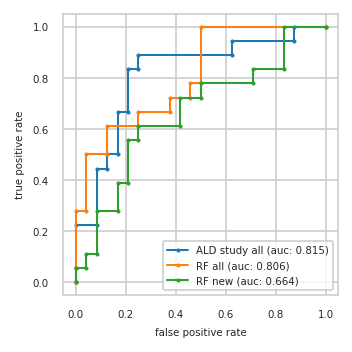

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.222  0.000 0.278  0.042 0.056
3          0.083 0.222  0.042 0.278  0.042 0.111
4          0.083 0.444  0.042 0.500  0.083 0.111
5          0.125 0.444  0.125 0.500  0.083 0.278
6          0.125 0.500  0.125 0.611  0.167 0.278
7          0.167 0.500  0.250 0.611  0.167 0.389
8          0.167 0.667  0.250 0.667  0.208 0.389
9          0.208 0.667  0.375 0.667  0.208 0.556
10         0.208 0.833  0.375 0.722  0.250 0.556
11         0.250 0.833  0.458 0.722  0.250 0.611
12         0.250 0.889  0.458 0.778  0.417 0.611
13         0.625 0.889  0.500 0.778  0.417 0.722
14         0.625 0.944  0.500 1.000  0.500 0.722
15         0.875 0.944  1.000 1.000  0.500 0.778
16         0.875 1.000    NaN   NaN  0.708 0.778
17         1.000 1.000    NaN   NaN  0.708 0.833
18           NaN   NaN    NaN   NaN  0.833 0.833
19           NaN   NaN    NaN   NaN  0.833 1.000
20           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P00740;P00740-2,P01011,E5RJY1;E7ESM1;Q92597;Q92597-2;Q92597-3
2,Q9NR34,P08670,J3KSJ8;Q9UD71;Q9UD71-2
3,Q13231;Q13231-3,Q9Y2T3;Q9Y2T3-3,P51688
4,P04075,P61981,Q96GD0
5,C9JF17;P05090,P15151-2,P31321
6,P61981,P14174,O95497
7,P14174,P04075,A0A0J9YW36;Q9NZ72;Q9NZ72-2
8,Q9Y2T3;Q9Y2T3-3,P63104,A0A075B7B8


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


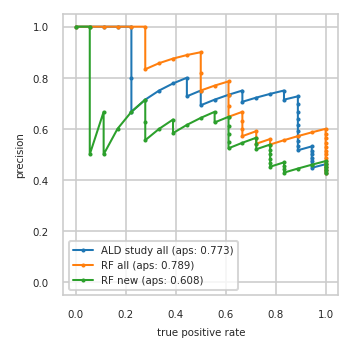

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.447 0.944     0.474 1.000     0.474 1.000
5          0.459 0.944     0.486 1.000     0.459 0.944
6          0.472 0.944     0.500 1.000     0.444 0.889
7          0.486 0.944     0.514 1.000     0.429 0.833
8          0.500 0.944     0.529 1.000     0.441 0.833
9          0.515 0.944     0.545 1.000     0.455 0.833
10         0.531 0.944     0.562 1.000     0.469 0.833
11         0.516 0.889     0.581 1.000     0.452 0.778
12         0.533 0.889     0.600 1.000     0.467 0.778
13         0.552 0.889     0.586 0.944     0.483 0.778
14         0.571 0.889     0.571 0.889     0.500 0.778
15         0.593 0.889     0.556 0.833     0.519 0.778
16         0.615 0.889     0.538 0.778     0.538 0.778
17         0.640 0.889     0.560 0.778     0.520 0.722
18         0.667 0.889     0.542 0.722     0.542 0.722
19         0.696 0.889     0.565 0.722     0.565 0.722
20         0.727 0.889     0.591 0.722     0.545 0.667
21         0.714 0.833     0.571 0.667     0.524 0.611
22         0.750 0.833     0.600 0.667     0.550 0.611
23         0.737 0.778     0.632 0.667     0.579 0.611
24         0.722 0.722     0.667 0.667     0.611 0.611
25         0.706 0.667     0.647 0.611     0.647 0.611
26         0.750 0.667     0.688 0.611     0.625 0.556
27         0.733 0.611     0.733 0.611     0.667 0.556
28         0.714 0.556     0.786 0.611     0.643 0.500
29         0.692 0.500     0.769 0.556     0.615 0.444
30         0.750 0.500     0.750 0.500     0.583 0.389
31         0.727 0.444     0.818 0.500     0.636 0.389
32         0.800 0.444     0.900 0.500     0.600 0.333
33         0.778 0.389     0.889 0.444     0.556 0.278
34         0.750 0.333     0.875 0.389     0.625 0.278
35         0.714 0.278     0.857 0.333     0.714 0.278
36         0.667 0.222     0.833 0.278     0.667 0.222
37         0.800 0.222     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


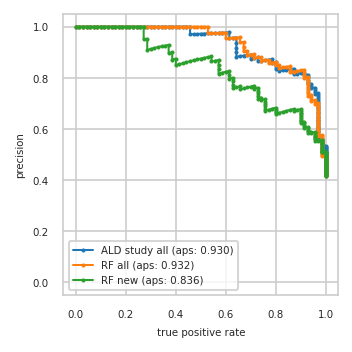

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


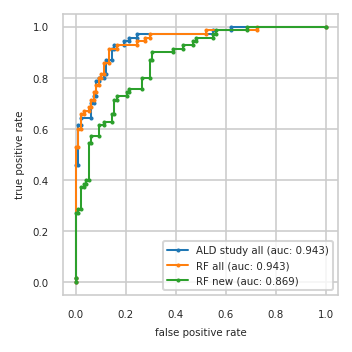

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}